Starting the training


<ipython-input-4-11d3e0701068>:127: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  states_tensor = torch.FloatTensor(states)


Thread 0, Episode 0/375, Reward: 11.0
Thread 2, Episode 0/375, Reward: 11.0
Thread 3, Episode 0/375, Reward: 20.0
Thread 2, Episode 1/375, Reward: 15.0
Thread 1, Episode 0/375, Reward: 40.0
Thread 0, Episode 1/375, Reward: 24.0
Thread 3, Episode 1/375, Reward: 21.0
Thread 2, Episode 2/375, Reward: 11.0
Thread 1, Episode 1/375, Reward: 16.0
Thread 0, Episode 2/375, Reward: 13.0
Thread 3, Episode 2/375, Reward: 16.0
Thread 2, Episode 3/375, Reward: 18.0
Thread 0, Episode 3/375, Reward: 13.0
Thread 1, Episode 2/375, Reward: 18.0
Thread 3, Episode 3/375, Reward: 10.0
Thread 0, Episode 4/375, Reward: 10.0
Thread 2, Episode 4/375, Reward: 20.0
Thread 1, Episode 3/375, Reward: 15.0
Thread 3, Episode 4/375, Reward: 16.0
Thread 0, Episode 5/375, Reward: 12.0
Thread 3, Episode 5/375, Reward: 13.0
Thread 1, Episode 4/375, Reward: 16.0
Thread 2, Episode 5/375, Reward: 23.0
Thread 0, Episode 6/375, Reward: 13.0
Thread 1, Episode 5/375, Reward: 11.0
Thread 3, Episode 6/375, Reward: 23.0
Thread 0, Ep

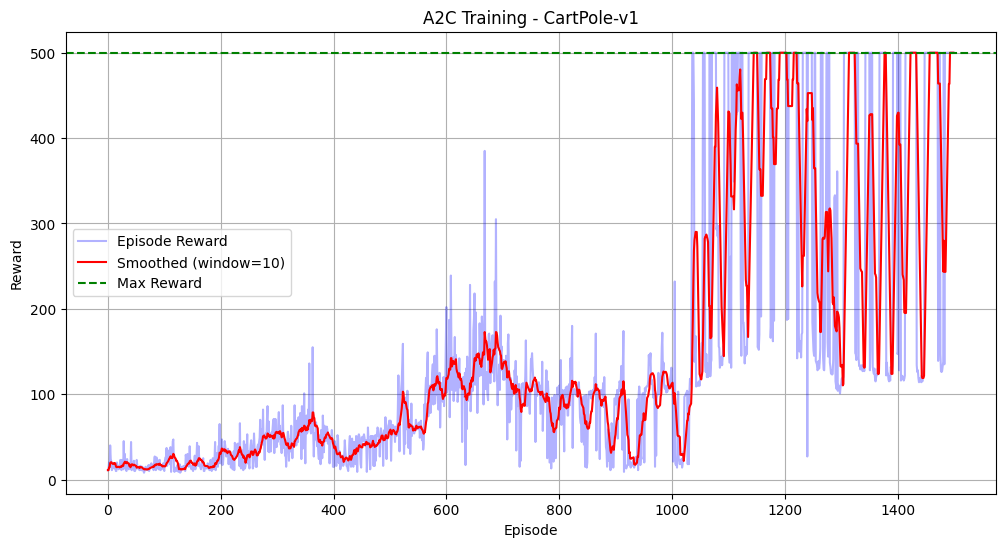

Evaluating the model
Evaluation results: Mean reward = 500.00
Max reward = 500.0, Min reward = 500.0
Standard deviation = 0.00


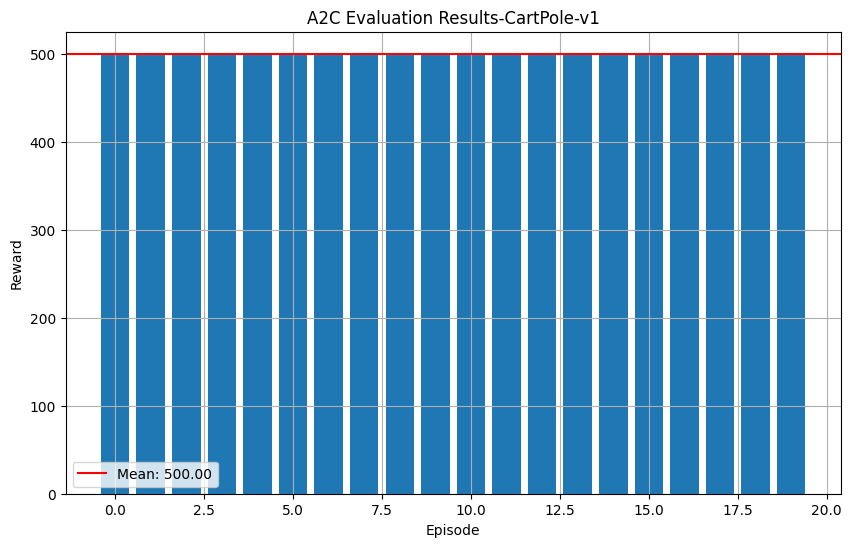

In [4]:
import os
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from queue import Queue
from threading import Thread, Lock
import time

class A2CNetwork(nn.Module):
    def __init__(self, input_dim, action_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
        )
        self.policy = nn.Sequential(
            nn.Linear(128, action_dim)
        )
        self.value = nn.Linear(128, 1)

    def forward(self, x):
        x = self.shared(x)
        return self.policy(x), self.value(x)

class RunningMeanStd:
    def __init__(self, epsilon=1e-4, shape=()):
        self.mean = np.zeros(shape, 'float64')
        self.var = np.ones(shape, 'float64')
        self.count = epsilon
        self.epsilon = epsilon

    def update(self, x):
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0]
        self.update_from_moments(batch_mean, batch_var, batch_count)

    def update_from_moments(self, batch_mean, batch_var, batch_count):
        self.mean, self.var, self.count = update_mean_var_count_from_moments(
            self.mean, self.var, self.count, batch_mean, batch_var, batch_count)

    def normalize(self, x):
        return (x - self.mean) / np.sqrt(self.var + self.epsilon)


def update_mean_var_count_from_moments(mean, var, count, batch_mean, batch_var, batch_count):
    delta = batch_mean - mean
    tot_count = count + batch_count
    new_mean = mean + delta * batch_count / tot_count
    m_a = var * count
    m_b = batch_var * batch_count
    M2 = m_a + m_b + np.square(delta) * count * batch_count / tot_count
    new_var = M2 / tot_count
    new_count = tot_count

    return new_mean, new_var, new_count

def compute_gae(rewards, values, next_value, dones, gamma=0.99, lam=0.95):
    gae = 0
    returns = []
    for i in reversed(range(len(rewards))):
        if i == len(rewards) - 1:
            delta = rewards[i] + gamma * next_value * (1 - dones[i]) - values[i]
        else:
            delta = rewards[i] + gamma * values[i + 1] * (1 - dones[i]) - values[i]
        gae = delta + gamma * lam * (1 - dones[i]) * gae
        returns.insert(0, gae + values[i])
    return torch.FloatTensor(returns)

def a2c_worker(env_name, global_model, optimizer, queue, thread_id, state_normalizer,
               model_lock, normalizer_lock, episodes_per_thread=375,
               gamma=0.99, entropy_coef=0.01):
    env = gym.make(env_name)
    episode_rewards = []
    best_reward = -float('inf')

    for episode in range(episodes_per_thread):
        state, _ = env.reset()
        states, actions, rewards, values, dones = [], [], [], [], []
        episode_states = []
        episode_reward = 0
        done = False
        exploration_prob = max(0.05, 0.5 * (1 - episode / episodes_per_thread))

        while not done:
            episode_states.append(state.copy())
            with normalizer_lock:
                norm_state = state_normalizer.normalize(state)

            state_tensor = torch.FloatTensor(norm_state).unsqueeze(0)
            with model_lock:
                with torch.no_grad():
                    logits, value = global_model(state_tensor)
            if np.random.random() < exploration_prob:
                action = env.action_space.sample()
            else:
                action = torch.argmax(logits, dim=1).item()
            next_state, reward, terminated, truncated, _ = env.step(action)
            states.append(norm_state)
            actions.append(action)
            rewards.append(reward)
            values.append(value.item())
            dones.append(1.0 if terminated or truncated else 0.0)

            episode_reward += reward
            state = next_state
            done = terminated or truncated

        with normalizer_lock:
            state_normalizer.update(np.array(episode_states))
        with normalizer_lock:
            norm_next_state = state_normalizer.normalize(state)

        next_state_tensor = torch.FloatTensor(norm_next_state).unsqueeze(0)
        with model_lock:
            with torch.no_grad():
                _, next_value = global_model(next_state_tensor)
                next_value = next_value.item()
        returns = compute_gae(rewards, values, next_value, dones, gamma=gamma)
        advantages = returns - torch.FloatTensor(values)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        states_tensor = torch.FloatTensor(states)
        actions_tensor = torch.LongTensor(actions)
        with model_lock:
            logits, values_pred = global_model(states_tensor)
            dist = torch.distributions.Categorical(logits=logits)
            log_probs = dist.log_prob(actions_tensor)
            entropy = dist.entropy().mean()
            actor_loss = -(log_probs * advantages).mean()
            critic_loss = 0.5 * ((values_pred.squeeze() - returns) ** 2).mean()
            loss = actor_loss + critic_loss - entropy_coef * entropy
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(global_model.parameters(), 0.5)
            optimizer.step()
        episode_rewards.append(episode_reward)
        best_reward = max(best_reward, episode_reward)
        queue.put((thread_id, episode, episode_reward))

    env.close()
    return episode_rewards
def train_multithreaded(env_name="CartPole-v1", total_episodes=1500, num_threads=2,
                        learning_rate=0.0003, gamma=0.99, entropy_coef=0.01):
    torch.manual_seed(42)
    np.random.seed(42)
    env = gym.make(env_name)
    input_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    env.close()
    state_normalizer = RunningMeanStd(shape=env.observation_space.shape)
    global_model = A2CNetwork(input_dim, action_dim)
    global_model.share_memory()
    optimizer = optim.Adam(global_model.parameters(), lr=learning_rate)
    queue = Queue()
    threads = []
    all_rewards = []
    model_lock = Lock()
    normalizer_lock = Lock()
    episodes_per_thread = total_episodes // num_threads
    for thread_id in range(num_threads):
        thread = Thread(target=a2c_worker,
                        args=(env_name, global_model, optimizer, queue, thread_id,
                              state_normalizer, model_lock, normalizer_lock,
                              episodes_per_thread, gamma, entropy_coef))
        threads.append(thread)
        thread.start()
    episode_data = [[] for _ in range(num_threads)]
    for _ in range(total_episodes):
        thread_id, episode, reward = queue.get()
        episode_data[thread_id].append((episode, reward))
        print(f"Thread {thread_id}, Episode {episode}/{episodes_per_thread}, Reward: {reward}")
        all_rewards.append(reward)
    for thread in threads:
        thread.join()
    torch.save({
        'model_state_dict': global_model.state_dict(),
        'normalizer_mean': state_normalizer.mean,
        'normalizer_var': state_normalizer.var,
    }, "fixed_a2c_cartpole_model.pth")

    return all_rewards, global_model, state_normalizer

def evaluate_model(env_name, model, state_normalizer, num_episodes=20):
    env = gym.make(env_name, render_mode=None)
    rewards = []

    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0
        while not done:
            norm_state = state_normalizer.normalize(state)
            state_tensor = torch.FloatTensor(norm_state).unsqueeze(0)
            with torch.no_grad():
                logits, _ = model(state_tensor)
            action = torch.argmax(logits, dim=1).item()
            state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            done = terminated or truncated

        rewards.append(total_reward)
    env.close()
    return rewards

def plot_rewards(rewards, window=10):
    plt.figure(figsize=(12, 6))
    plt.plot(rewards, alpha=0.3, color='blue', label='Episode Reward')
    if len(rewards) > window:
        smooth_rewards = []
        for i in range(len(rewards)):
            if i < window:
                smooth_rewards.append(np.mean(rewards[:i+1]))
            else:
                smooth_rewards.append(np.mean(rewards[i-window+1:i+1]))
        plt.plot(smooth_rewards, color='red', label=f'Smoothed (window={window})')

    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('A2C Training - CartPole-v1')
    plt.axhline(y=500, color='green', linestyle='--', label='Max Reward')
    plt.grid(True)
    plt.legend()
    plt.savefig('trainingrewards.png')
    plt.show()


if __name__ == "__main__":
    num_threads = 4
    total_episodes = 1500
    learning_rate = 0.0005
    gamma = 0.99
    entropy_coef = 0.01
    print("Starting the training")
    train_rewards, model, state_normalizer = train_multithreaded(
        num_threads=num_threads,
        total_episodes=total_episodes,
        learning_rate=learning_rate,
        gamma=gamma,
        entropy_coef=entropy_coef
    )

    plot_rewards(train_rewards)
    print("Evaluating the model")
    eval_rewards = evaluate_model("CartPole-v1", model, state_normalizer, num_episodes=20)
    print(f"Evaluation results: Mean reward = {np.mean(eval_rewards):.2f}")
    print(f"Max reward = {np.max(eval_rewards)}, Min reward = {np.min(eval_rewards)}")
    print(f"Standard deviation = {np.std(eval_rewards):.2f}")
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(eval_rewards)), eval_rewards)
    plt.axhline(y=np.mean(eval_rewards), color='red', linestyle='-', label=f'Mean: {np.mean(eval_rewards):.2f}')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('A2C Evaluation Results-CartPole-v1')
    plt.grid(True)
    plt.legend()
    plt.savefig('evaluationrewards.png')
    plt.show()